In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.18.0
2.0.2
0.6.0


In [2]:
!pip install sentencepiece

In [3]:
!pip install konlpy

In [4]:
!pip install sentencepiece

# 네이버 영화리뷰 감정 분석 데이터 준비

In [3]:
import pandas as pd
train_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
test_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
train_data = pd.read_table(train_url)
test_data = pd.read_table(test_url)

# 확인
print(train_data.head())
print(test_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0



# 데이터 전처리



In [4]:
import re

import re
# from hanspell import spell_checker

def clean_korean_text(text):
    if not isinstance(text, str):
        return ""

    # # 맞춤법 교정
    # try:
    #     text = spell_checker.check(text).checked
    # except:
    #     pass  # 너무 많거나 서버 에러 시 생략

    # 1. 특수기호도 유지하고 싶을 경우 (예: ! ? . ,)
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Zㅜㅠㅋㅎ\s.,!?]", "", text)


    # 2. 부정 강조 기호 정리
    text = re.sub(r"[-ㅡ]{2,}", "ㅡ", text)

    # 3. ㅋㅋ, ㅎㅎ, ㅠㅠ 등 축약
    text = re.sub(r"[ㅋㅎㅜㅠ]{2,}", lambda m: m.group(0)[0], text)

    # 4. 반복 문자 제거 (예: 아아아아 → 아)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # # 5. 의미 없는 자음 반복 제거 (ㅇㅇ, ㄱㄱ, ㄴㄴ 등)
    # text = re.sub(r"\b[ㄱ-ㅎ]{2,}\b", "", text)

    # 6. 공백 정리
    text = re.sub(r"\s+", " ", text).strip()

    return text

train_data['document'] = train_data['document'].apply(clean_korean_text)

In [7]:
train_data['document'].sample(5)

,document
26163,왜 경북지역엔 항상 나혼자산다를 다운받아봐야하나요 대구mbc에서 맨날 딴것만 보여주...
43412,다음편이기대되네요 빨리나와라
15835,피비빼고 다 최악
116401,몇번을 봤지만 한장면 빼고는 기억이 나지않는.
40416,"내용부족으로 중강 중간 이가 빠진 듯한 스토리 전개에 지루하고, 이야기 하고자하는 ..."


문장 개수: 150000
최단 길이: 0
최장 길이: 140
평균 길이: 33


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

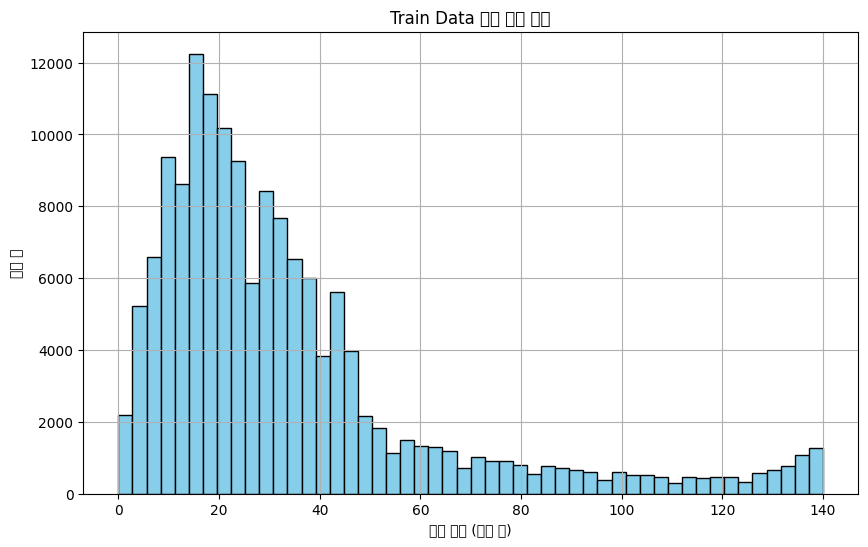

In [5]:
import matplotlib.pyplot as plt

# 문장 길이 리스트 생성
document_lengths = train_data['document'].dropna().apply(lambda x: len(str(x))).tolist()

# 기본 통계 출력
print(f"문장 개수: {len(document_lengths)}")
print(f"최단 길이: {min(document_lengths)}")
print(f"최장 길이: {max(document_lengths)}")
print(f"평균 길이: {sum(document_lengths) // len(document_lengths)}")

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Train Data 문장 길이 분포")
plt.xlabel("문장 길이 (글자 수)")
plt.ylabel("문장 수")
plt.grid(True)
plt.show()


In [6]:
# 결측값 제거
train_data = train_data.dropna(subset=['document'])

# 문자열로 변환 및 앞뒤 공백 제거
train_data['document'] = train_data['document'].astype(str).str.strip()

# 길이 기준 필터링 (5글자 이상만)
train_data = train_data[train_data['document'].apply(lambda x: len(x) >= 5)]

# 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])

# 인덱스 리셋
train_data = train_data.reset_index(drop=True)

print(f"✅ 전처리 후 문장 수: {len(train_data)}")


✅ 전처리 후 문장 수: 142861


In [7]:
train_data['document'].sample(5)

,document
73968,영화를 보는내내 긴장을 놓을 수가 없었던.엄청나다.
33848,좋아요좋아요좋아요좋아요좋아요
49410,소설 보고 기대했는데 긴장감도 없고 캐릭터를 너무 바꿔놨음
140788,1점 더 줘서 아까웠지만 찍은 스텝들과 많은 사람을위해 1점 더 선사한다.
97377,진짜진짜 최고라네!! 찬양하세


## filtered_corpus ,텍스트만 추출, 공백 제거, 베어있는 문장 제거

In [8]:
# 텍스트만 추출
train_corpus = [
    str(s).strip()
    for s in train_data['document']
    if isinstance(s, str) and str(s).strip()
]

test_corpus = [
    str(s).strip()
    for s in test_data['document']
    if isinstance(s, str) and str(s).strip()
]

# 중복 제거된 학습 코퍼스
filtered_corpus = list(set(train_corpus))

print("✔️ 중복 제거 전 문장 수:", len(train_corpus))
print("✔️ 중복 제거 후 문장 수:", len(filtered_corpus))


✔️ 중복 제거 전 문장 수: 142861
✔️ 중복 제거 후 문장 수: 142861


문장의 최단 길이: 5
문장의 최장 길이: 140
문장의 평균 길이: 35


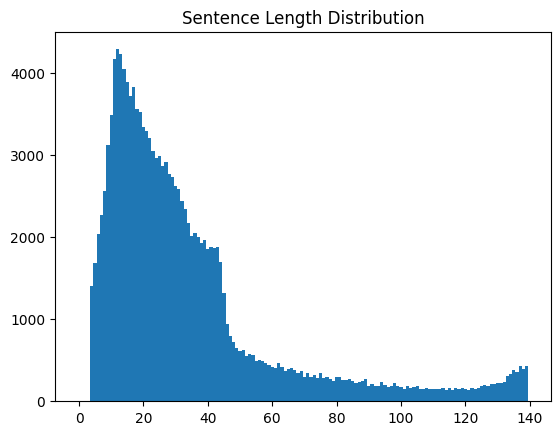

In [11]:
# 문장 길이 분석
#데이터의 중복 제거
min_len = 999
max_len = 0
sum_len = 0


for sen in filtered_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(filtered_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

max_len = 60

In [12]:
max_len = 60

In [14]:
# 문장 길이 5 이상만 사용
filtered_corpus = [s for s in filtered_corpus if len(s) >= 5]

In [15]:
import os
def write_temp_file(corpus, save_path):
    with open(save_path, 'w') as f:
        for line in corpus:
            if line.strip():
                f.write(line.strip() + '\n')

temp_file = os.path.expanduser('sp_corpus.txt')
write_temp_file(filtered_corpus, temp_file)

In [16]:
#SentencePice 모델 활용
import sentencepiece as spm

s = spm.SentencePieceProcessor()
s.Load('./spm_models/spm_unigram_8000.model')

#SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나')
print(tokensIDs)

#SentencePIece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', nbest_size=-1, alpha=0.1))

#SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1830, 8, 4, 4950, 161, 1420, 31, 227, 8, 8, 174, 417, 353, 1334, 6407, 732, 406]
['▁흠', '.', '..', '포스터', '보고', '▁초', '딩', '영', '화', '줄', '..', '..', '오', '버', '연기', '조차', '▁가볍지', '▁않', '구나']
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나


In [17]:
def save_corpus_to_file(corpus, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        for line in corpus:
            if isinstance(line, str) and line.strip():
                f.write(line.strip() + '\n')
filtered_corpus_path = 'filtered_corpus.txt'
save_corpus_to_file(filtered_corpus, filtered_corpus_path)

In [18]:
import sentencepiece as spm
import os

def train_sentencepiece_models(corpus_path, save_dir, vocab_sizes=[8000, 10000], model_types=['unigram', 'bpe']):
    os.makedirs(save_dir, exist_ok=True)

    for vocab_size in vocab_sizes:
        for model_type in model_types:
            model_prefix = f"{save_dir}/spm_{model_type}_{vocab_size}"
            print(f"🚀 Training: {model_prefix}")

            spm.SentencePieceTrainer.Train(
                input=corpus_path,
                model_prefix=model_prefix,
                vocab_size=vocab_size,
                model_type=model_type,
                character_coverage=1.0,  # 한글 필수
                pad_id=0,
                unk_id=1,
                bos_id=2,
                eos_id=3,
                user_defined_symbols=[]  # 필요 시 커스터마이징
            )

    print("✅ 모든 SentencePiece 모델 학습 완료.")


In [19]:
# 2. 학습 실행
train_sentencepiece_models(
    corpus_path='./filtered_corpus.txt',
    save_dir='./spm_models',
    vocab_sizes=[10000, 16000],
    model_types=['unigram', 'bpe']
)

🚀 Training: ./spm_models/spm_unigram_10000
🚀 Training: ./spm_models/spm_bpe_10000
🚀 Training: ./spm_models/spm_unigram_16000
🚀 Training: ./spm_models/spm_bpe_16000
✅ 모든 SentencePiece 모델 학습 완료.


In [20]:
import sentencepiece as spm

model_path = './spm_models/spm_unigram_10000.model'  # 예시 경로
sp = spm.SentencePieceProcessor()
loaded = sp.load(model_path)

print("모델 로드 성공 여부:", loaded)  # True가 출력되어야 함


모델 로드 성공 여부: True


In [21]:
print("✅ Vocab size:", sp.get_piece_size())

# 상위 토큰 10개 출력
for i in range(10):
    print(f"{i}: {sp.id_to_piece(i)}")


✅ Vocab size: 10000
0: <pad>
1: <unk>
2: <s>
3: </s>
4: .
5: ▁
6: 이
7: ▁영화
8: ..
9: 의


In [22]:
sample = "오랜만에? 기대가 없어서? 볼만했던 넷플 1위. 모성애를 쫒아가지 못한 찌질남이지만 나름 몰입도 있다"
ids = sp.encode_as_ids(sample)
pieces = sp.encode_as_pieces(sample)

print("✅ 원문:", sample)
print("🔢 ID:", ids)
print("🔡 Pieces:", pieces)
print("🪄 복원:", sp.decode_ids(ids))


✅ 원문: 오랜만에? 기대가 없어서? 볼만했던 넷플 1위. 모성애를 쫒아가지 못한 찌질남이지만 나름 몰입도 있다
🔢 ID: [621, 18, 235, 10, 1401, 18, 1488, 396, 5, 6191, 984, 59, 323, 4, 7754, 23, 5, 9474, 45, 2280, 737, 3264, 265, 799, 579, 748, 337]
🔡 Pieces: ['▁오랜만에', '?', '▁기대', '가', '▁없어서', '?', '▁볼만', '했던', '▁', '넷', '플', '▁1', '위', '.', '▁모성애', '를', '▁', '쫒', '아', '가지', '▁못한', '▁찌질', '남', '이지만', '▁나름', '▁몰입도', '▁있다']
🪄 복원: 오랜만에? 기대가 없어서? 볼만했던 넷플 1위. 모성애를 쫒아가지 못한 찌질남이지만 나름 몰입도 있다


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sentencepiece as spm

import sentencepiece as spm
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sp_tokenize(model_path, corpus, vocab_path=None, max_len=60):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)

    tensor = []
    for s in corpus:
        ids = sp.encode_as_ids(str(s))
        if len(ids) == 0:
            ids = [sp.unk_id()]  # 빈 문장 처리
        tensor.append(ids)

    tensor = pad_sequences(tensor, padding='post', maxlen=max_len)

    if vocab_path is None:
        vocab_path = model_path.replace(".model", ".vocab")

    word_index = {}
    index_word = {}
    with open(vocab_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            token = line.split('\t')[0]
            word_index[token] = idx
            index_word[idx] = token

    return tensor, word_index, index_word



In [32]:
train_data['document'].apply(lambda x: len(str(x).strip())).describe()


,document
count,142861.000000
mean,35.426904
std,29.059411
min,5.000000
25%,16.000000
50%,27.000000
75%,42.000000
max,140.000000


In [33]:
(train_data['document'].str.strip() == "").sum()


np.int64(0)

##  SentencePiece 기반 RNN 모델 학습

## unigram, 10000 vocab size
- 0.8519

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_simple_model(vocab_size):
    model = Sequential([
        Embedding(vocab_size, 128),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [35]:
# ✅ 모델 경로 통일
model_path = "spm_models/spm_unigram_10000.model"

# ✅ Tokenization
# 평균 + 상위 25% 문장 커버를 위한 적정 길이 설정
MAX_LEN = 40  # 또는 50 정도도 가능

X_train_sp, word_index, index_word = sp_tokenize(
    model_path, train_data['document'], max_len=MAX_LEN
)
X_test_sp, _, _ = sp_tokenize(
    model_path, test_data['document'], max_len=MAX_LEN
)


# ✅ Vocab size
vocab_size = len(word_index)
y_train = train_data['label'].values
y_test = test_data['label'].values




In [36]:
# ✅ 모델 정의 및 학습
model_sp = build_rnn_model(vocab_size)
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model_sp.fit(X_train_sp, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stop])

# ✅ 평가
acc_sp = model_sp.evaluate(X_test_sp, y_test)[1]
print(f"✅ SentencePiece + LSTM Test Accuracy: {acc_sp:.4f}")

Epoch 1/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.6298 - loss: 0.5937 - val_accuracy: 0.8480 - val_loss: 0.3470
Epoch 2/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8667 - loss: 0.3174 - val_accuracy: 0.8601 - val_loss: 0.3267
Epoch 3/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8923 - loss: 0.2586 - val_accuracy: 0.8561 - val_loss: 0.3338
Epoch 4/20
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9111 - loss: 0.2188 - val_accuracy: 0.8552 - val_loss: 0.3628
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8530 - loss: 0.3411
✅ SentencePiece + BiLSTM Test Accuracy: 0.8519


In [30]:
# print("Y 분포:", np.bincount(y_train))  # 라벨 분포 확인
# print("문장 샘플:", train_data['document'].iloc[10])  # 전처리 후 문장
# print("토큰:", sp.encode_as_pieces(train_data['document'].iloc[0]))
# print("토큰 ID:", sp.encode_as_ids(train_data['document'].iloc[0]))
# print("UNK 비율:", sum(1 for i in sp.encode_as_ids(train_data['document'].iloc[0]) if i == sp.unk_id()) / len(sp.encode_as_ids(train_data['document'].iloc[0])))



Y 분포: [71761 71100]
문장 샘플: 걍인피니트가짱이다.진짜짱이다
토큰: ['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
토큰 ID: [63, 791, 8, 31, 2033, 65, 1686]
UNK 비율: 0.0


In [27]:
# from collections import Counter
# non_pad = [token for s in X_train_sp for token in s if token != 0]
# print(Counter(non_pad).most_common(10))


### unigram, 16000 vocab size
- test accuracy : 0.8492

In [37]:
# ✅ 모델 경로 통일
model_path = "spm_models/spm_unigram_16000.model"

# ✅ Tokenization
# 평균 + 상위 25% 문장 커버를 위한 적정 길이 설정
MAX_LEN = 40  # 또는 50 정도도 가능

X_train_sp, word_index, index_word = sp_tokenize(
    model_path, train_data['document'], max_len=MAX_LEN
)
X_test_sp, _, _ = sp_tokenize(
    model_path, test_data['document'], max_len=MAX_LEN
)


# ✅ Vocab size
vocab_size = len(word_index)
y_train = train_data['label'].values
y_test = test_data['label'].values

# ✅ 학습
model_sp = build_rnn_model(vocab_size)
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model_sp.fit(X_train_sp, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks = [early_stop])

# ✅ 평가
acc_sp = model_sp.evaluate(X_test_sp, y_test)[1]
print(f"✅ SentencePiece(bpe, 16000) + RNN Test Accuracy: {acc_sp:.4f}")

Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6188 - loss: 0.6188 - val_accuracy: 0.8431 - val_loss: 0.3591
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8679 - loss: 0.3223 - val_accuracy: 0.8591 - val_loss: 0.3309
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9014 - loss: 0.2445 - val_accuracy: 0.8580 - val_loss: 0.3493
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9229 - loss: 0.1937 - val_accuracy: 0.8521 - val_loss: 0.4082
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8516 - loss: 0.3459
✅ SentencePiece(bpe, 8000) + RNN Test Accuracy: 0.8492


## bpe, 10000 vocab size
- 0.8499

In [38]:
# ✅ 모델 경로 통일
model_path = "spm_models/spm_bpe_10000.model"

# ✅ Tokenization
# 평균 + 상위 25% 문장 커버를 위한 적정 길이 설정
MAX_LEN = 40  # 또는 50 정도도 가능

X_train_sp, word_index, index_word = sp_tokenize(
    model_path, train_data['document'], max_len=MAX_LEN
)
X_test_sp, _, _ = sp_tokenize(
    model_path, test_data['document'], max_len=MAX_LEN
)


# ✅ Vocab size
vocab_size = len(word_index)
y_train = train_data['label'].values
y_test = test_data['label'].values

# ✅ 학습
model_sp = build_rnn_model(vocab_size)
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model_sp.fit(X_train_sp, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks = [early_stop])

# ✅ 평가
acc_sp = model_sp.evaluate(X_test_sp, y_test)[1]
print(f"✅ SentencePiece(bpe, 10000) + RNN Test Accuracy: {acc_sp:.4f}")

Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.5584 - loss: 0.6749 - val_accuracy: 0.7847 - val_loss: 0.4956
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8113 - loss: 0.4338 - val_accuracy: 0.8448 - val_loss: 0.3513
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8730 - loss: 0.3050 - val_accuracy: 0.8565 - val_loss: 0.3376
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8917 - loss: 0.2631 - val_accuracy: 0.8577 - val_loss: 0.3446
Epoch 5/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9056 - loss: 0.2333 - val_accuracy: 0.8557 - val_loss: 0.3736
Epoch 6/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9219 - loss: 0.1997 - val_accuracy: 0.8485 - val_loss: 0.3934
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8481 - loss: 0.3564
✅ SentencePiece(bpe, 10000) + RNN Test Accuracy: 0.8499


## bpe, 16000 vocab size
- 0.8515

In [39]:
# ✅ 모델 경로 통일
model_path = "spm_models/spm_bpe_16000.model"

# ✅ Tokenization
# 평균 + 상위 25% 문장 커버를 위한 적정 길이 설정
MAX_LEN = 40  # 또는 50 정도도 가능

X_train_sp, word_index, index_word = sp_tokenize(
    model_path, train_data['document'], max_len=MAX_LEN
)
X_test_sp, _, _ = sp_tokenize(
    model_path, test_data['document'], max_len=MAX_LEN
)


# ✅ Vocab size
vocab_size = len(word_index)
y_train = train_data['label'].values
y_test = test_data['label'].values

# ✅ 학습
model_sp = build_rnn_model(vocab_size)
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model_sp.fit(X_train_sp, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks = [early_stop])

# ✅ 평가
acc_sp = model_sp.evaluate(X_test_sp, y_test)[1]
print(f"✅ SentencePiece(bpe, 16000) + RNN Test Accuracy: {acc_sp:.4f}")

Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5871 - loss: 0.6488 - val_accuracy: 0.8098 - val_loss: 0.4305
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8270 - loss: 0.4028 - val_accuracy: 0.8538 - val_loss: 0.3359
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8884 - loss: 0.2726 - val_accuracy: 0.8572 - val_loss: 0.3382
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9165 - loss: 0.2067 - val_accuracy: 0.8550 - val_loss: 0.3691
Epoch 5/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9356 - loss: 0.1660 - val_accuracy: 0.8482 - val_loss: 0.4141
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8517 - loss: 0.3511
✅ SentencePiece(bpe, 16000) + RNN Test Accuracy: 0.8515


## KoNLPy okt 데이터 전처리 및 모델 학습
-  0.8519

In [47]:
from konlpy.tag import Okt, Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import re


In [43]:
# 1. 전처리 + 토큰화
okt = Okt()
train_data['clean'] = train_data['document'].apply(clean_korean_text)
test_data['clean'] = test_data['document'].apply(clean_korean_text)

train_data['tokens_okt'] = train_data['clean'].apply(lambda x: okt.morphs(x, stem=True))
test_data['tokens_okt'] = test_data['clean'].apply(lambda x: okt.morphs(x, stem=True))

# 2. Tokenizer 학습
tokenizer_okt = Tokenizer()
tokenizer_okt.fit_on_texts(train_data['tokens_okt'])

# 3. 시퀀스 변환 + 패딩
X_train_okt = pad_sequences(tokenizer_okt.texts_to_sequences(train_data['tokens_okt']), maxlen=40)
X_test_okt = pad_sequences(tokenizer_okt.texts_to_sequences(test_data['tokens_okt']), maxlen=40)


In [44]:

#4. 학습
vocab_size_okt = len(tokenizer_okt.word_index) + 1
model_okt = build_simple_model(vocab_size_okt)
model_okt.fit(X_train_okt, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
print("✅ OKT Test Accuracy:", model_okt.evaluate(X_test_okt, y_test)[1])


Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7894 - loss: 0.4419 - val_accuracy: 0.8536 - val_loss: 0.3416
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8862 - loss: 0.2736 - val_accuracy: 0.8579 - val_loss: 0.3315
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9138 - loss: 0.2123 - val_accuracy: 0.8573 - val_loss: 0.3367
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9359 - loss: 0.1648 - val_accuracy: 0.8579 - val_loss: 0.3836
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8519 - loss: 0.3397
✅ OKT Test Accuracy: 0.8519999980926514


## KoNLPs Mecab
- 0.8593

In [52]:
# 1. 필요한 패키지 설치
!apt install -y curl git build-essential

# 2. MeCab 설치 스크립트 실행 (Konlpy 공식)
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
curl is already the newest version (7.81.0-1ubuntu1.20).
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
Install mecab-python
/tmp /content
/content
Processing /tmp/mecab-python-0.996
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [53]:
# 기존 mecab-python 실패 시 대안
!pip install mecab-python3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 32.4 MB/s eta 0:00:00


In [20]:
# Mecab 설치 필요: !apt install g++ openjdk-8-jdk python3-dev python3-pip python3-setuptools python3-wheel -y
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


train_data['clean'] = train_data['document'].apply(clean_korean_text)
test_data['clean'] = test_data['document'].apply(clean_korean_text)
mecab = Mecab()
train_data['tokens_mecab'] = train_data['clean'].apply(lambda x: mecab.morphs(x))
test_data['tokens_mecab'] = test_data['clean'].apply(lambda x: mecab.morphs(x))

tokenizer_mecab = Tokenizer()
tokenizer_mecab.fit_on_texts(train_data['tokens_mecab'])

X_train_mecab = pad_sequences(tokenizer_mecab.texts_to_sequences(train_data['tokens_mecab']), maxlen=40)
X_test_mecab = pad_sequences(tokenizer_mecab.texts_to_sequences(test_data['tokens_mecab']), maxlen=40)


In [29]:
# 학습
y_train = train_data['label'].values
y_test = test_data['label'].values
vocab_size_mecab = len(tokenizer_mecab.word_index) + 1
model_mecab = build_simple_model(vocab_size_mecab)
model_mecab.fit(X_train_mecab, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
print("✅ mecab Test Accuracy:", model_mecab.evaluate(X_test_mecab, y_test)[1])


Epoch 1/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7850 - loss: 0.4472 - val_accuracy: 0.8584 - val_loss: 0.3291
Epoch 2/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8933 - loss: 0.2643 - val_accuracy: 0.8625 - val_loss: 0.3230
Epoch 3/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9215 - loss: 0.1995 - val_accuracy: 0.8618 - val_loss: 0.3378
Epoch 4/10
893/893 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9417 - loss: 0.1535 - val_accuracy: 0.8589 - val_loss: 0.3831
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8601 - loss: 0.3267
✅ mecab Test Accuracy: 0.8593199849128723


# 성능 비교
- **형태소 기반 토크나이저(Mecab, Okt)**가 SentencePiece보다 약간 더 우수한 성능을 보임.

- 특히 **Mecab은 가장 높은 정확도(0.8593)**로 성능이 가장 뛰어남.

- SentencePiece도 매우 근접한 성능을 보이며, 특히 unigram 방식이 BPE보다 약간 더 안정적.

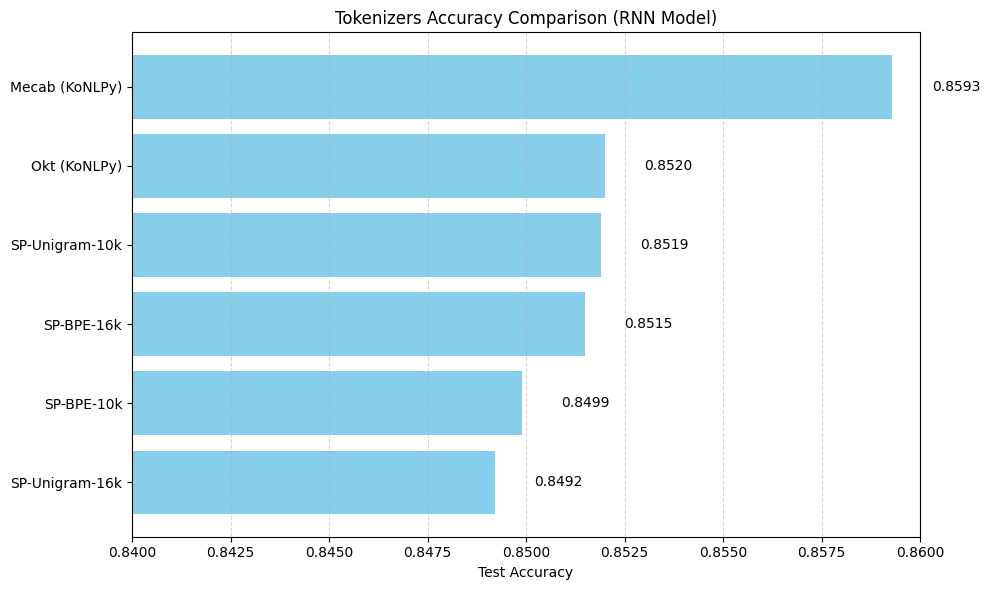

In [30]:
import matplotlib.pyplot as plt

# 데이터 정의
labels = [
    "Mecab (KoNLPy)",
    "Okt (KoNLPy)",
    "SP-Unigram-10k",
    "SP-BPE-16k",
    "SP-BPE-10k",
    "SP-Unigram-16k"
]
accuracies = [0.8593, 0.8520, 0.8519, 0.8515, 0.8499, 0.8492]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, accuracies, color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("Tokenizers Accuracy Comparison (RNN Model)")
plt.gca().invert_yaxis()  # 순위를 위쪽에 높은 순으로

# 정확도 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f"{width:.4f}", va='center')

plt.xlim(0.84, 0.86)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
